# IFRC Project Status Distribution

This notebook fetches project data from the IFRC GO API and visualizes the distribution of project statuses.

## 1. Import Required Libraries

In [1]:
import os
import requests
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()
print('Environment variables loaded successfully!')

Environment variables loaded successfully!


## 2. Define Functions

### 2.1 Get Authorization Headers

In [2]:
def get_auth_headers():
    """
    Get authorization headers using token from environment variable.
    
    Returns:
        dict: Headers dictionary with Authorization token
    
    Raises:
        ValueError: If IFRC_API_TOKEN is not found in environment
    """
    auth_token = os.getenv('IFRC_API_TOKEN')
    
    if not auth_token:
        raise ValueError('IFRC_API_TOKEN not found in environment. Please check your .env file.')
    
    return {"Authorization": f"Token {auth_token}"}

### 2.2 Fetch Project Data

In [3]:
def fetch_project_data(api_url, params):
    """
    Fetch all project data from the API with pagination and count by status.
    
    Args:
        api_url: The API endpoint URL
        params: Dictionary of query parameters
    
    Returns:
        dict: Dictionary with status names as keys and counts as values
    """
    headers = get_auth_headers()
    all_projects = []
    
    # Make a copy of params to avoid modifying the original
    params = params.copy()

    # Fetch data from all pages of the API endpoint
    while True:
        response = requests.get(api_url, params=params, headers=headers)
        
        # Check for successful response
        if response.status_code != 200:
            print(f"Error: API returned status code {response.status_code}")
            break
        
        # Cache the JSON response (fix: avoid calling response.json() twice)
        data = response.json()
        page_data = data.get("results", [])
        all_projects.extend(page_data)
        
        print(f"Fetched {len(page_data)} projects (total: {len(all_projects)})")

        # Check if there are more pages
        next_page = data.get("next")
        if next_page:
            params["offset"] += params["limit"]  # Move to the next page
        else:
            break  # No more pages, exit the loop

    # Process data and generate status counts
    status_counts = {}
    for project in all_projects:
        status = project.get("status_display")
        if status:
            status_counts[status] = status_counts.get(status, 0) + 1

    return status_counts

### 2.3 Plot Status Distribution

In [4]:
def plot_status_distribution(status_counts):
    """
    Create a bar chart showing the distribution of project statuses.
    
    Args:
        status_counts: Dictionary with status names as keys and counts as values
    """
    if not status_counts:
        print("No data to display.")
        return
    
    status_labels = list(status_counts.keys())
    status_data = list(status_counts.values())

    # Generate a list of colors based on the number of status_labels
    num_colors = len(status_labels)
    colors = plt.cm.viridis(np.linspace(0, 1, num_colors))

    # Create a bar chart
    plt.figure(figsize=(10, 6))
    bars = plt.bar(status_labels, status_data, color=colors)

    # Annotate bars with data labels
    # FIX: Changed 'bars' to 'bar', 'labels' to 'label', and display count values
    for bar, count in zip(bars, status_data):
        plt.text(
            bar.get_x() + bar.get_width() / 2,  # FIX: use 'bar' not 'bars'
            bar.get_height() + 0.1,              # FIX: use 'bar' not 'bars'
            str(count),                          # FIX: display the count, not label
            ha='center',
            va='bottom',
            fontsize=11,
            fontweight='bold'
        )
    
    plt.xlabel('Status', fontsize=12)
    plt.ylabel('# of Projects', fontsize=12)
    plt.title('Project Status Distribution', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha="right", fontsize=11)
    plt.yticks(fontsize=11)
    plt.grid(True, axis='y', linestyle='dotted', alpha=0.5, color='black')
    plt.tight_layout()
    plt.show()

## 3. Fetch Project Data

In [5]:
# Define the API endpoint URL and parameters
api_url = "https://goadmin.ifrc.org/api/v2/project/"
params = {
    "country_iso3": "SDN",  # Sudan
    "limit": 50,
    "offset": 0,
}

# Fetch project data
status_counts = fetch_project_data(api_url, params)

print(f"\nStatus distribution:")
for status, count in status_counts.items():
    print(f"  {status}: {count}")

Fetched 50 projects (total: 50)
Fetched 5 projects (total: 55)

Status distribution:
  Ongoing: 4
  Completed: 51


## 4. Visualize the Data

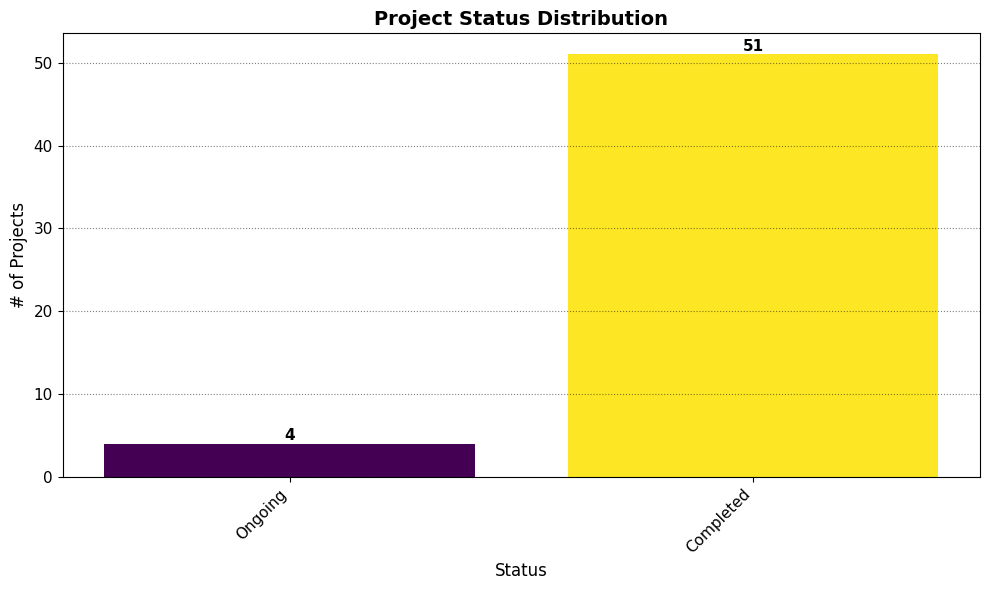

In [6]:
# Plot the status distribution
plot_status_distribution(status_counts)